<a href="https://colab.research.google.com/github/gsh150801/100-Days-Of-ML-Code/blob/master/%E2%80%9CCS224W_Project_Disease_Gene_Interactions_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Disease-gene association prediction tutorial

*By Kathy Fan, Terence Tam, Anthony Tzen as part of the Stanford CS224W course project.*

This is the Colab tutorial corresponding to our blog post. Feel free to follow along while reading the tutorial, or explore this as a standalone code notebook! The organization of the colab is meant to start from a simple base model, and gradually build complexity as we go.

# 1) Install the necessary packages needed for processing the dataset.

First, under the Runtime menu, change the runtime type so that you have GPU support. Our dataset is small enough such that a GPU shouldn't be strictly required, but having it will help your code run faster.

Next we will install the following packages:

*   torch_geometric
*   torch_sparse
*   torch_scatter

In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))
print(torch.version.cuda)

PyTorch has version 1.10.0+cu111
11.1


In [ ]:
! pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
! pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
! pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html


Below are all the other imports you will need in this tutorial.

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import string
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.transforms as T

from plotly import graph_objs as go
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from torch_geometric.data import Data, download_url, extract_gz
from torch_geometric.nn import GAE, GCNConv, VGAE
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import train_test_split_edges, negative_sampling, degree


Also, set the seeds for this colab for reproducibility.

In [ ]:
# set the seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# 2) Download and extract the **DG-AssocMiner** graph data.

To start, we can download the datafile directly from the SNAP website to this Colab instance.

In [ ]:
url = 'http://snap.stanford.edu/biodata/datasets/10012/files/DG-AssocMiner_miner-disease-gene.tsv.gz'
extract_gz(download_url(url, '.'), '.')

data_path = "./DG-AssocMiner_miner-disease-gene.tsv"

Using existing file DG-AssocMiner_miner-disease-gene.tsv.gz
Extracting ./DG-AssocMiner_miner-disease-gene.tsv.gz


In [ ]:
# Take a brief look at the structure of the data.
# Note that column names are ["# Disease ID", "Disease Name", "Gene ID"].
df = pd.read_csv(data_path, sep="\t")
print(df.head(), '\n')

  # Disease ID              Disease Name  Gene ID
0     C0036095  Salivary Gland Neoplasms     1462
1     C0036095  Salivary Gland Neoplasms     1612
2     C0036095  Salivary Gland Neoplasms      182
3     C0036095  Salivary Gland Neoplasms     2011
4     C0036095  Salivary Gland Neoplasms     2019 



We want to assign each node a unique integer index. So, the 519 disease nodes would be indexed 0 through 518, and the 7294 gene nodes would be indexed 519 through 7812.

The edge index list is a list of pairs (x1, x2), where x1 is the index of the head node and x2 is the index of the tail node.

The below routines help generate these node indices and constructs the edge index accordingly. This is necessary for storing the data as a [Data](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html?highlight=heterodata#torch_geometric.data.Data) PyTorch Geometric data object. Our approach is based on PyTorch Geometric tutorial that can be found [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/load_csv.html). Note that we create both the edge index and a reverse edge index; representing both directions of a single edge allows us to model undirected edges in the graph.

In [ ]:
def load_node_mapping(datafile_path, index_col, offset=0):
  """
  Maps each distinct node to a unique integer index.

  Args: datafile_path, string name of the tsv file containing the graph data
        index_col, string name of the column containing the nodes of concern
        offset, amount to shift the generated indexes by
  Returns: the mapping from node name to integer index
  """
  df = pd.read_csv(datafile_path, index_col=index_col, sep="\t")
  mapping = {index_id: i + offset for i, index_id in enumerate(df.index.unique())}
  return mapping

def load_edge_list(datafile_path, src_col, src_mapping, dst_col, dst_mapping):
  """
  Given node mappings, returns edge list in terms of node integer indices.

  Args: datafile_path, string name of the tsv file containing the graph data
        src_col, string name of the column corresponding to source nodes
        src_mapping, mapping from source node name to integer index
  Returns: the mapping from node name to integer index
  """
  df = pd.read_csv(datafile_path, sep="\t")
  src_nodes = [src_mapping[index] for index in df[src_col]]
  dst_nodes = [dst_mapping[index] for index in df[dst_col]]
  edge_index = torch.tensor([src_nodes, dst_nodes])
  return edge_index

def initialize_data(datafile_path, num_features=1):
  """
  Given a tsv file specifying disease-gene interactions, index the nodes and
  construct a Data object.
  """
  # Get disease node mapping and gene node mapping.
  # Each node type has its own set of integer ids.
  dz_col, gene_col = "# Disease ID", "Gene ID"
  dz_mapping = load_node_mapping(datafile_path, dz_col, offset=0)
  gene_mapping = load_node_mapping(datafile_path, gene_col, offset=519)

  # Get edge index in terms of the integer indeces assigned to the nodes.
  edge_index = load_edge_list(
      datafile_path, dz_col, dz_mapping, gene_col, gene_mapping)

  # Add the reverse direction (aka make it a undirected graph)
  rev_edge_index = load_edge_list(
      datafile_path, gene_col, gene_mapping, dz_col, dz_mapping)

  # Construct a Data object.
  data = Data()
  data.num_nodes = len(dz_mapping) + len(gene_mapping)
  data.edge_index = torch.cat((edge_index, rev_edge_index), dim=1)
  # pretend we have uniform node features
  data.x = torch.ones((data.num_nodes, num_features))

  return data, gene_mapping, dz_mapping

With the routines defined, we plug in our dataset to get our Data object.

In [ ]:
# Read data and construct Data object.
data_object, gene_mapping, dz_mapping = initialize_data(data_path)
print(data_object)
print("Number of genes:", len(gene_mapping))
print("Number of diseases:", len(dz_mapping))

Data(num_nodes=7813, edge_index=[2, 42714], x=[7813, 1])
Number of genes: 7294
Number of diseases: 519


From here, we (optionally) can do some exploratory analysis of the data to get a sense of what the graph looks like! For example, the below code prints out the nodes of highest degree.

In [ ]:
# Additional analysis (optional, can skip)

# Recall, dz_mapping maps dz_ids to node_index.
reverse_dz_mapping = {j: i for i,j in dz_mapping.items()}
reverse_gene_mapping = {j: i for i,j in gene_mapping.items()}

degrees = degree(data_object.edge_index[0]).numpy()
sorted_degrees_i = np.argsort(-1* degrees)

print("Disease Nodes of highest degree")
top_k = 10
num_dz_nodes = 0
for i in sorted_degrees_i:
  if i < 519:   # Disease nodes have node indeces < 519
    node_id = reverse_dz_mapping[i]
    node_description = df[df["# Disease ID"] == node_id]["Disease Name"].drop_duplicates().iloc[0]
    node_degree = degrees[i]
    print("node_index=" + str(i), "node_degree=" + str(int(node_degree)),
          node_id, node_description)
    num_dz_nodes += 1
    if num_dz_nodes >= top_k:
      break

print("\nGene Nodes of highest degree")
num_gene_nodes = 0
for i in sorted_degrees_i:
  if i >= 519:
    node_id = reverse_gene_mapping[i]
    node_degree = degrees[i]
    print("node_index=" + str(i), "node_degree=" + str(int(node_degree)), node_id)
    num_gene_nodes += 1
    if num_gene_nodes >= top_k:
      break

Disease Nodes of highest degree
node_index=119 node_degree=485 C0033578 Prostatic Neoplasms
node_index=472 node_degree=450 C0017661 IGA Glomerulonephritis
node_index=280 node_degree=433 C1458155 Mammary Neoplasms
node_index=461 node_degree=298 C0028754 Obesity
node_index=184 node_degree=293 C0031117 Peripheral Neuropathy
node_index=479 node_degree=284 C0038356 Stomach Neoplasms
node_index=161 node_degree=280 C0036341 Schizophrenia
node_index=131 node_degree=254 C0004352 Autistic Disorder
node_index=91 node_degree=232 C0009404 Colorectal Neoplasms
node_index=155 node_degree=222 C2239176 Liver carcinoma

Gene Nodes of highest degree
node_index=654 node_degree=115 7124
node_index=577 node_degree=96 6648
node_index=714 node_degree=83 5743
node_index=622 node_degree=79 3569
node_index=656 node_degree=68 7157
node_index=620 node_degree=61 3553
node_index=691 node_degree=58 7040
node_index=972 node_degree=56 4524
node_index=658 node_degree=50 7422
node_index=866 node_degree=49 3162



# 3) Add initial node features and construct train/valid/test splits.

For the main section of the tutorial, we will use uniform node features at the start of training. This means that we will be fully relying on the structural info of the data. As we shall see later, this is enough to give us good results when using GAE and VGAE models.

See section (8) below to see how other features may be used instead.

In [ ]:
#@title Dataset Configuration

NUM_FEATURES =   20#@param {type: "integer"}

In [ ]:
data_object.x = torch.ones((data_object.num_nodes, NUM_FEATURES))
print("Using dummy embeddings as initial node features.")
print("Number of features set to ", NUM_FEATURES)

Using dummy embeddings as initial node features.
Number of features set to  20


Construct the dataset splits for the selected dataset. We are chooing 15% of the edges to be test edges, and about 5% of the edges as validation edges.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.15, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True),
])

train_dataset, val_dataset, test_dataset = transform(data_object)
print("Train Data:\n", train_dataset)
print("Validation Data:\n", val_dataset)
print("Test Data:\n", test_dataset)

Train Data:
 Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 20], pos_edge_label=[17087], pos_edge_label_index=[2, 17087], neg_edge_label=[17087], neg_edge_label_index=[2, 17087])
Validation Data:
 Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 20], pos_edge_label=[1067], pos_edge_label_index=[2, 1067], neg_edge_label=[1067], neg_edge_label_index=[2, 1067])
Test Data:
 Data(num_nodes=7813, edge_index=[2, 36308], x=[7813, 20], pos_edge_label=[3203], pos_edge_label_index=[2, 3203], neg_edge_label=[3203], neg_edge_label_index=[2, 3203])


# 4) Analysis and Visualization helpers.
In this section, we provide the code for generating some useful graphs to understand how our model behaves before, during, and after training. Go ahead and run all these cells so that you can use them later.

In [ ]:
def get_mapping():
  data_path = "./DG-AssocMiner_miner-disease-gene.tsv"
  df = pd.read_csv(data_path, index_col="Disease Name", sep="\t")
  disease_mapping = [index_id for index_id in enumerate(df.index.unique())]
  df = pd.read_csv(data_path, index_col="Gene ID", sep="\t")
  gene_mapping = [index_id[1] for index_id in enumerate(df.index.unique())]
  mapping = disease_mapping + gene_mapping
  return mapping

def visualize_tsne_embeddings(model, data, title, perplexity=30.0,
                              labeled=False, labels=[]):
  """Visualizes node embeddings in 2D space with t-SNE.

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
          nodes and the rest are gene nodes
        title, title of the plot
        perplexity, t-SNE hyperparameter for perplexity
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index)
  ax1, ax2 = zip(*TSNE(n_components=2, learning_rate='auto', perplexity=perplexity,
                       init='random').fit_transform(z.detach().cpu().numpy()))

  fig = px.scatter(x=ax1, y=ax2, color=['r']*519 + ['g']*7294,
                   hover_data=[get_mapping()],
                   title=title)

  if labeled:
    for i in labels:
      fig.add_annotation(x=ax1[i], y=ax2[i],
                         text=str(i), showarrow=False)
  fig.show()

def visualize_pca_embeddings(model, data, title, labeled=False, labels=[]):
  """Visualizes node embeddings in 2D space with PCA (components=2)

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
          nodes and the rest are gene nodes
        title, title of the plot
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index)

  pca = PCA(n_components=2)
  components = pca.fit_transform(z.detach().cpu().numpy())
  fig = px.scatter(components, x=0, y=1, color=['r']*519 + ['g']*7294,
                   hover_data=[get_mapping()], title=title)

  if labeled:
    for i in labels:
      fig.add_annotation(x=components[:,0][i], y=components[:,1][i],
                         text=str(i), showarrow=False)
  fig.show()

In [ ]:
def plot_roc_curve(model, data):
  """Visualizes ROC curve of model predictions

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
  """
  model.eval()

  x = data.x
  z = model.encode(x, data.edge_index)

  pos_preds = model.decode(z, data.pos_edge_label_index, sigmoid=True)
  neg_preds = model.decode(z, data.neg_edge_label_index, sigmoid=True)
  preds = torch.cat([pos_preds, neg_preds], dim=0)
  preds = preds.detach().cpu().numpy()

  labels = torch.cat((data.pos_edge_label, data.neg_edge_label), dim=0)
  labels = labels.detach().cpu().numpy()
  fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

  # Using J-statistic: https://en.wikipedia.org/wiki/Youden%27s_J_statistic
  J = tpr - fpr
  ix = np.argmax(J)
  best_thresh = thresholds[ix]
  print('Best Threshold=%f' % (best_thresh))

  roc_auc = metrics.roc_auc_score(labels, preds)

  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--') # diagonal roc curve of a random classifier
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best=%0.2f' % best_thresh)
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc = 'lower right')
  plt.title('ROC curve for model predictions')
  plt.show()

In [ ]:
def plot_training_stats(title, losses, test_auc, test_ap, train_auc, train_ap):
  """Plots evolution of loss and metrics during training

  Args: losses, test_auc, test_ap, train_auc, and train_ap should be lists
    outputted by the training process.
  """
  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(test_auc, "r-", label="test AUC")
  p3, = ax2.plot(test_ap, "g-", label="test AP")
  p4, = ax2.plot(train_auc, "o-", label="train AUC")
  p5, = ax2.plot(train_ap, "v-", label="train AP")
  plt.legend(handles=[p1, p2, p3, p4, p5])
  plt.show()

In [ ]:
def get_edge_dot_products(data, model, num_dz_nodes=519):
  """
  A pair of nodes (u,v) is predicted to be connected with an edge if the dot
  product between the learned embeddings of u and v is high. This function
  computes and returns the dot product of all pairs of (dz_node, gene_node).

  Args:
    data, the data_object containing the original node featues
    model, the model that will be used to encode the data
    num_dz_nodes, the number of disease nodes; used to differentiate between
      disease and gene node embeddings
  Returns:
    dot_products, a numpy 2D array of shape (num_dz_nodes, num_gene_nodes)
      containing the dot product between each (dz_node, gene_node) pair.
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index).detach().numpy()
  dz_z = z[:num_dz_nodes, :]
  gene_z = z[num_dz_nodes:, :]

  dot_products = np.einsum('ai,bi->ab', dz_z, gene_z)
  return dot_products   # numpy array of shape (num_dz_nodes, num_gene_nodes)


def get_ranked_edges(data_object, model, num_dz_nodes=519):
  """
  Ranks all potential edges as predicted by the model.

  Args:
    data, the data_object containing the original node featues
    model, the model that will be used to encode the data
    num_dz_nodes, the number of disease nodes; used to differentiate between
      disease and gene node embeddings
  Returns:
    ranked_edge_list, a full edge list ranked by the likelihood of the edge
      being a positive edge, in decreasing order
    ranked_dot_products, a list of the dot products of each edge's node
      embeddings, ranked in decreasing order
  """
  # Get dot products
  edge_dot_products = get_edge_dot_products(data_object, model, num_dz_nodes=num_dz_nodes)
  num_possible_edges = edge_dot_products.shape[0] * edge_dot_products.shape[1]

  # Get indeces, ranked by dot product in descending order. This is a tuple (indeces[0], indeces[1]).
  ranked_edges = np.unravel_index(np.argsort(-1 * edge_dot_products, axis=None), edge_dot_products.shape)
  assert len(ranked_edges[0]) == num_possible_edges

  # Get the corresponding, ranked edge list and ranked dot products. Note that
  # we need to add an offset for the gene_node indeces.
  offset = np.array([np.zeros(num_possible_edges, dtype=int), num_dz_nodes + np.ones(num_possible_edges, dtype=int)]).T
  ranked_edge_list = np.dstack(ranked_edges)[0] + offset
  assert ranked_edge_list.shape[0] == num_possible_edges

  # Get the corresponding ranked dot products
  ranked_dot_products = edge_dot_products[ranked_edges]
  assert ranked_dot_products.shape[0] == num_possible_edges

  return ranked_edge_list, ranked_dot_products


# 5) Initialize and train the GAE model.

In this section, we will create and train the Graph Autoencoder (GAE) model. The GAE module is provided in PyG. At a high level, it is a combination of an encoder and decoder that works with graph data. Since we are using the default dot product decoder, all we need to specify is the encoder class. Here, we construct an encoder (`GCNEncoder`) using two `GCNConv` layers with dropout in between.

We also initialize an Adam optimizer for training.

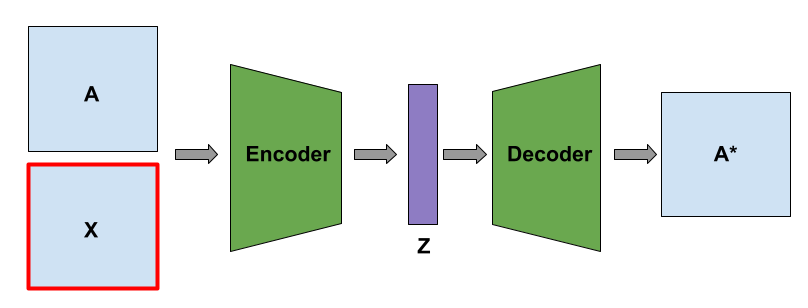

In [ ]:
#@title Model & Training Configuration

HIDDEN_SIZE = 200  #@param {type: "integer"}

OUT_CHANNELS = 20  #@param {type: "integer"}

EPOCHS =   40#@param {type: "integer"}

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(hidden_size, out_channels, cached=True) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)


gae_model = GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
gae_model = gae_model.to(device)

In the training loop, we optimize the model based on its reconstruction loss, a loss function provided by PyG. Roughly speaking, it calculates the difference between the output of the model's encoder and the true adjacency matrix of the graph, in hopes that minimizing this will help the model learn a meaningful encoding of the graph.

In [ ]:
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index.to(device))
    loss.backward(retain_graph=True)
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    return gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)


Before we train the model, let's visualize how the encoder initially embeds the nodes. Here, we are using t-SNE and PCA to project the embeddings into a 2D space. We use red for the disease nodes and blue for the gene nodes (note that the red nodes can overlap over the blue nodes).

We also labeled some nodes throughout these visualizations to provide some sense of how the nodes' embeddings evolve throughout this process. For example, node 280 is a disease node of high degree, and thus tends to be more separated from the rest of the nodes in the PCA visualizations - farther distance from the other nodes means higher dot products with the other nodes' embeddings, which means the decoder would predict more edges with this high degree node.

In [ ]:
visualize_tsne_embeddings(gae_model, train_dataset, 'Untrained GAE: train set embeddings t-SNE', labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:998: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
visualize_pca_embeddings(gae_model, train_dataset, 'Untrained GAE: train set embeddings PCA', labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:998: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Now let's train the model! We keep track of a few scores at the end of each epoch. First is the loss obtained by the model. Next, we keep track of both training and test set performance. We measure the performance in terms of two metrics: the ROC-AUC score, and the Average Precision (AP) score.

In [ ]:
losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []


optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.01)

for epoch in range(1, EPOCHS + 1):
    loss = gae_train(train_dataset, gae_model, optimizer)
    losses.append(loss)
    auc, ap = gae_test(test_dataset, gae_model)
    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = gae_test(train_dataset, gae_model)

    train_aucs.append(train_auc)
    train_aps.append(train_ap)

    print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

Epoch: 001, test AUC: 0.9466, test AP: 0.9407, train AUC: 0.9523, train AP: 0.9440, loss:1.3811
Epoch: 002, test AUC: 0.9495, test AP: 0.9421, train AUC: 0.9551, train AP: 0.9454, loss:1.2973
Epoch: 003, test AUC: 0.9510, test AP: 0.9424, train AUC: 0.9564, train AP: 0.9457, loss:1.2064
Epoch: 004, test AUC: 0.9512, test AP: 0.9424, train AUC: 0.9566, train AP: 0.9456, loss:1.2916
Epoch: 005, test AUC: 0.9514, test AP: 0.9424, train AUC: 0.9567, train AP: 0.9455, loss:1.2188
Epoch: 006, test AUC: 0.9517, test AP: 0.9423, train AUC: 0.9569, train AP: 0.9452, loss:1.1909
Epoch: 007, test AUC: 0.9522, test AP: 0.9423, train AUC: 0.9573, train AP: 0.9449, loss:1.2086
Epoch: 008, test AUC: 0.9527, test AP: 0.9422, train AUC: 0.9576, train AP: 0.9446, loss:1.2235
Epoch: 009, test AUC: 0.9532, test AP: 0.9421, train AUC: 0.9580, train AP: 0.9443, loss:1.2113
Epoch: 010, test AUC: 0.9536, test AP: 0.9420, train AUC: 0.9582, train AP: 0.9440, loss:1.1949
Epoch: 011, test AUC: 0.9538, test AP: 0

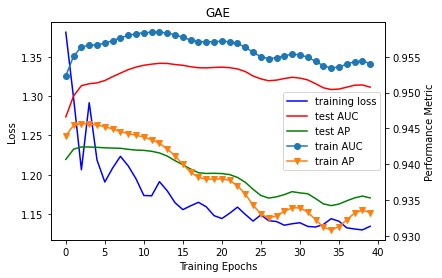

In [ ]:
plot_training_stats('GAE', losses, test_auc, test_ap, train_aucs, train_aps)

Best Threshold=0.625216


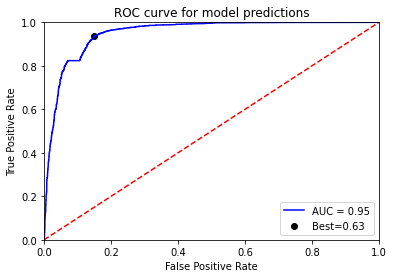

In [ ]:
plot_roc_curve(gae_model, test_dataset)

Finally, we can visualize the embeddings again -- this time, with the trained model.

In [ ]:
visualize_tsne_embeddings(
    gae_model, train_dataset, title='Trained GAE: train set embeddings',
    perplexity=5, labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:998: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
visualize_pca_embeddings(
    gae_model, train_dataset, title='Trained GAE: train set embeddings',
    labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:998: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



# 6) Initialize and train the VGAE model.

This section is largely identical to section 6, except we construct a Variational GAE (VGAE) model instead of a GAE. Since most of the code is the same, we will only explain the VGAE model itself.

Similar to the GAE, the VGAE module is provided by PyG and consists of an encoder and decoder. We use the default decoder again and provide the implementation for our encoder, `VariationalGCNEncoder`. Recall that the key characteristic of a VGAE is that rather than embedding nodes with specific vectors in the embedding space, it predicts a distribution for the node embeddings. Hence, the main difference from the `GCNEncoder` used in the GAE is that the last `GCNConv` layer is actually two separate `GCNConv` objects: one of them predicts the mean of the distribution, and one of them predicts the standard deviation.

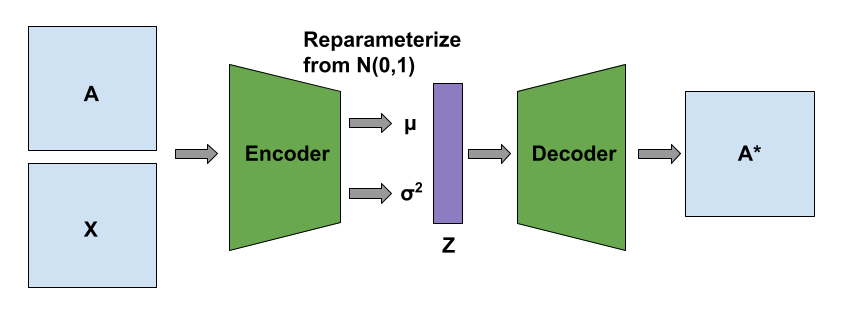

In [ ]:
#@title Model & Training Configuration

HIDDEN_SIZE = 200  #@param {type: "integer"}

OUT_CHANNELS = 20  #@param {type: "integer"}

EPOCHS =   40#@param {type: "integer"}

In [ ]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=False)
        self.conv_mu = GCNConv(hidden_size, out_channels, cached=False)
        self.conv_logstd = GCNConv(hidden_size, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv_mu(x_temp2, edge_index), self.conv_logstd(x_temp2, edge_index)


vgae_model = VGAE(VariationalGCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, dropout=0.5))
vgae_model = vgae_model.to(device)

Note there is a small difference in the training function: in the loss equation, we now consider an extra term, which is the KL loss.

In [ ]:
def vgae_train(train_data, vgae_model, optimizer):
    optimizer.zero_grad()
    vgae_model.train()
    z = vgae_model.encode(train_data.x, train_data.edge_index)
    loss = (
        vgae_model.recon_loss(z, train_data.pos_edge_label_index.to(device)) +
        (1 / train_data.num_nodes) * vgae_model.kl_loss()
    )
    loss.backward(retain_graph=True)
    optimizer.step()
    return float(loss)

@torch.no_grad()
def vgae_test(test_data, vgae_model):
    vgae_model.eval()
    z = vgae_model.encode(test_data.x, test_data.edge_index)
    return vgae_model.test(z, test_data.pos_edge_label_index,
                      test_data.neg_edge_label_index)

In [ ]:
losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []


optimizer = torch.optim.Adam(vgae_model.parameters(), lr=0.01)

for epoch in range(1, EPOCHS + 1):
    loss = vgae_train(train_dataset, vgae_model, optimizer)
    losses.append(loss)
    auc, ap = vgae_test(test_dataset, vgae_model)
    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = vgae_test(train_dataset, vgae_model)

    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

Epoch: 001, test AUC: 0.9346, test AP: 0.9326, train AUC: 0.9390, train AP: 0.9351, loss:3.7777
Epoch: 002, test AUC: 0.9466, test AP: 0.9413, train AUC: 0.9505, train AP: 0.9435, loss:3.4970
Epoch: 003, test AUC: 0.9514, test AP: 0.9439, train AUC: 0.9549, train AP: 0.9459, loss:3.1139
Epoch: 004, test AUC: 0.9530, test AP: 0.9445, train AUC: 0.9563, train AP: 0.9463, loss:2.7814
Epoch: 005, test AUC: 0.9536, test AP: 0.9446, train AUC: 0.9567, train AP: 0.9462, loss:2.4086
Epoch: 006, test AUC: 0.9538, test AP: 0.9446, train AUC: 0.9569, train AP: 0.9461, loss:2.1855
Epoch: 007, test AUC: 0.9539, test AP: 0.9446, train AUC: 0.9570, train AP: 0.9461, loss:1.9388
Epoch: 008, test AUC: 0.9539, test AP: 0.9445, train AUC: 0.9569, train AP: 0.9460, loss:1.7638
Epoch: 009, test AUC: 0.9537, test AP: 0.9444, train AUC: 0.9567, train AP: 0.9458, loss:1.5914
Epoch: 010, test AUC: 0.9537, test AP: 0.9444, train AUC: 0.9567, train AP: 0.9458, loss:1.4799
Epoch: 011, test AUC: 0.9543, test AP: 0

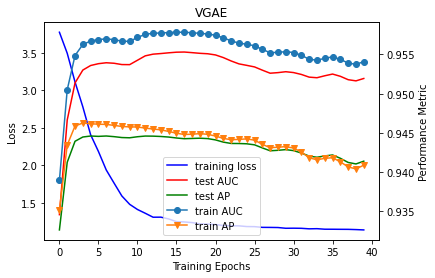

In [ ]:
plot_training_stats('VGAE', losses, test_auc, test_ap, train_aucs, train_aps)

Best Threshold=0.613678


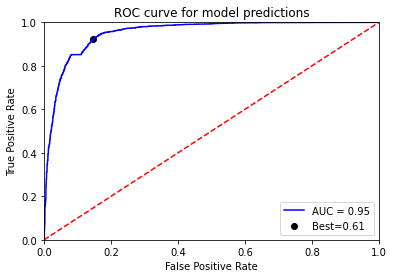

In [ ]:
plot_roc_curve(vgae_model, test_dataset)

In [ ]:
visualize_tsne_embeddings(
    vgae_model, train_dataset, title='Trained VGAE: train set embeddings',
    labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:998: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
visualize_pca_embeddings(
    vgae_model, train_dataset, title='Untrained GAE: train set embeddings',
    labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:998: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



# 7) Optional: explore different model hyperparameters.

As you may know, a lot of machine learning is picking the optimal set of hyperparameters such that your model performs at its best. In the previous tutorial sections, we specified values to use for initializing our models, based on what we found worked well. However, if you'd like to play with these parameters, we provide a helper function for performing hyperparameter search over either the GAE or VGAE model.

To use, specify the parameter values you'd like to try out in the `param_grid` argument, and pass in the training and validation splits of the data. The code will then initialize a separate model for every single combination of values specified by your parameter grid. It will also keep track of the performance of each and give a suggestion for the best parameters, out of the ones searched.

In [ ]:
def perform_hyperparameter_search(model_type, param_grid, train_set, val_set, save_weights=False, early_stop=False):
  default = {'lr': [0.01],
            'hidden_dim': [150, 200, 250],
             'num_features': [5],
             'out_channels': [20],
             'dropout': [.2, .5],
             'max_epochs': [200, 300]}

  for arg in default:
    if arg not in param_grid:
      param_grid[arg] = default[arg]
  grid = ParameterGrid(param_grid)
  ap_results = {}
  auc_results = {}

  eid = 0 # experiment id
  for params in grid:
    # Index of the model, represents the parameters
    index = '; '.join(x + '_' + str(y) for x, y in params.items())
    print(index)

    # Launch a training experiment using the current set of parameters
    val_ap, val_auc = launch_experiment(eid,
                   model_type,
                   params,
                   train_set,
                   val_set,
                   save_weights=save_weights,
                   early_stop=early_stop)
    eid += 1
    ap_results[index] = val_ap
    auc_results[index] = val_auc
    print("Validation AP and AUC:", val_ap, val_auc)

  # Select the best results
  best_ap_index = max(ap_results, key = ap_results.get)
  best_ap_model = (best_ap_index, ap_results[best_ap_index])

  best_auc_index = max(auc_results, key = auc_results.get)
  best_auc_model = (best_auc_index, auc_results[best_auc_index])

  return best_ap_model, best_auc_model

def launch_experiment(eid, model_type, params, train_set, val_set, save_weights=False, early_stop=False):
  # Construct the features to be used.
  train_set.x = torch.ones(train_set.num_nodes, params['num_features'])
  val_set.x = torch.ones(val_set.num_nodes, params['num_features'])

  # Initialize model
  if model_type == 'GAE':
    model = GAE(GCNEncoder(params['num_features'], params['hidden_dim'], params['out_channels'], params['dropout']))
  elif model_type == 'VGAE':
    model = VGAE(VariationalGCNEncoder(params['num_features'], params['hidden_dim'], params['out_channels'], params['dropout']))
  else:
    print("Unsupported model_type: must be GAE or VGAE")
    return

  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

  prev_train_loss = 0.1 # Set to a small non-zero value
  for epoch in range(params['max_epochs']):
    train_loss = train(model_type, model, optimizer, train_set)
    val_ap, val_auc = test(model, val_set)

    # we can also add logic here to save the weights of the model if this current epoch
    # gives the best performance so far. Mostly passing in eid to construct a filename
    # for saving the model weights.

    if early_stop:
      loss_delta = abs(train_loss - prev_train_loss)
      # Stop criteria:
      # loss changing <10% from previous epoch
      # we can also add a criteria like
      # validation ap less than train ap by more than 0.3.
      # the second criteria suggests the gap is large between train/valid results
      # meaning we could be overfitting if we continue.
      if loss_delta / prev_train_loss < 0.1:
        break

  return val_ap, val_auc

def train(model_type, model, optimizer, train_set):
  model.train()
  optimizer.zero_grad()
  z = model.encode(train_set.x, train_set.edge_index)
  if model_type == 'GAE':
    loss = model.recon_loss(z, train_set.edge_index)
  elif model_type == 'VGAE':
    loss = model.recon_loss(z, train_set.edge_index) + (1 / train_set.num_nodes) * model.kl_loss()
  else:
    print("Unsupported model_type: must be GAE or VGAE")
    return
  loss.backward()
  optimizer.step()
  return float(loss)

@torch.no_grad()
def test(model, test_set):
  model.eval()
  z = model.encode(test_set.x, test_set.edge_index)
  return model.test(z, test_set.pos_edge_label_index, test_set.neg_edge_label_index)


In [ ]:
param_grid = {
    'lr': [0.01],
    'hidden_dim': [200],
    'num_features': [15, 20, 25],
    'out_channels': [15, 20, 25],
    'dropout': [0.3, 0.5, 0.7],
    'max_epochs': [100],
}
best_ap_model, best_auc_model = perform_hyperparameter_search('VGAE', param_grid, train_dataset, val_dataset)
print("Best AP Model:", best_ap_model)
print("Best AUC Model:", best_auc_model)

dropout_0.3; hidden_dim_200; lr_0.01; max_epochs_100; num_features_15; out_channels_15
Validation AP and AUC: 0.9199539916503364 0.9162293163839461
dropout_0.3; hidden_dim_200; lr_0.01; max_epochs_100; num_features_15; out_channels_20
Validation AP and AUC: 0.9268288933841258 0.921250549817193
dropout_0.3; hidden_dim_200; lr_0.01; max_epochs_100; num_features_15; out_channels_25
Validation AP and AUC: 0.9252838630851945 0.9200793141116493
dropout_0.3; hidden_dim_200; lr_0.01; max_epochs_100; num_features_20; out_channels_15
Validation AP and AUC: 0.9285979047667567 0.9233110450580961
dropout_0.3; hidden_dim_200; lr_0.01; max_epochs_100; num_features_20; out_channels_20
Validation AP and AUC: 0.9113741986088578 0.9089716697630591
dropout_0.3; hidden_dim_200; lr_0.01; max_epochs_100; num_features_20; out_channels_25
Validation AP and AUC: 0.9281244702408193 0.9218332204297063
dropout_0.3; hidden_dim_200; lr_0.01; max_epochs_100; num_features_25; out_channels_15
Validation AP and AUC: 0.9

# 8) Advanced: Engineer gene and disease node features.

*This section is optional; if you're primarily interested in trying out the GAE/VGAE models, you may skip this section as we have already covered the main concepts in previous sections.*

With the **DG-AssocMiner** data extracted, we can train our model with dummy node features to start. We pick uniform vectors as the dummy feaures. In this case, our GCN performance would rely entirely on the structural properties of our training graph. As we previously saw, this turns out to be quite effective already, but we are leaving out some critical domain knowledge - namely, the disease and gene descriptions and properties.

Can we improve performance by adding some of this information to our initial node embeddings? In this section, we look to plug in some of this information by using gene and disease names to generate initial node feature embeddings.

## 8a: Fetch gene and disease descriptions.

First, we need to gather the word descriptions we will be using. In the **DG-AssocMiner** dataset, we already have names for the disease nodes. However, we are missing gene descriptions.

These gene descriptions are in a separate **GeneSynopsis** dataset (also available from the SNAP website). Note, though, that the **DG-AssocMiner** dataset uses *NCBI gene IDs* while the **GeneSynopsis** dataset uses the *ENSEMBL gene IDs*. Thus, our first step is to map the former to the latter IDs, and add the descriptions corresponding to these IDs to our input data.

> **IMPORTANT:** This part requires download an additional dataset for the NCBI IDs -> ENSEMBLE IDs mapping. Such a dataset can be found at the Ensembl BioMart site [here](http://www.ensembl.org/biomart/martview/85d67e7fa01d2ff276bb6cde0dc7d2fa?VIRTUALSCHEMANAME=default&ATTRIBUTES=hsapiens_gene_ensembl.default.feature_page.ensembl_gene_id|hsapiens_gene_ensembl.default.feature_page.ensembl_gene_id_version|hsapiens_gene_ensembl.default.feature_page.entrezgene_id&FILTERS=&VISIBLEPANEL=resultspanel) (click the "Go" button). We have provided a copy of it in a public Google Drive directory.
>
> An alternative would be to download the dataset and move it to this Colab's workspace before proceeding. Then, name the file `gene_ids.tsv` (and comment out the `gene_url` downloading part below).

In [ ]:
# This table (downloaded and uploaded from Ensembl BioMart site) acts as a mapping that
# maps ENSEMBL Gene Ids to the NCBI Gene Ids used by the Gene-Disease Assoc
# dataset that we are using.
gene_url = "https://drive.google.com/uc?export=download&id=1JlptlMtfZvholERGLoP0w22nMBM6LpAW"
download_url(gene_url, '.')
!mv ./uc ./gene_ids.tsv

gene_ids_data_path = "./gene_ids.tsv"

gene_ids_df = pd.read_csv(gene_ids_data_path, sep="\t")
gene_ids_df = gene_ids_df.rename(columns={
    "Gene stable ID": "ENSEMBL Gene ID",
    "Gene stable ID version": "ENSEMBL Gene ID Version",
    "NCBI gene (formerly Entrezgene) ID": "Gene ID"})
gene_ids_df = gene_ids_df.loc[:, ["ENSEMBL Gene ID", "Gene ID"]]

# Add new "ENSEMBL Gene ID" column to our existing Gene-Disease Assoc table.
new_df = pd.merge(df, gene_ids_df, left_on="Gene ID", right_on="Gene ID", how="left")
new_df["Gene ID"] = new_df["Gene ID"].astype(int)
print(new_df.loc[:, ["Gene ID", "ENSEMBL Gene ID", ]])  # To confirm mapping.


# Check how many NCBI Gene IDs were unable to be mapped to ENSEMBL Genes IDs.
print("Number of unmapped NCBI Genes:",
      new_df.drop_duplicates(subset="Gene ID")['ENSEMBL Gene ID'].isna().sum())

       Gene ID  ENSEMBL Gene ID
0         1462  ENSG00000038427
1         1612  ENSG00000196730
2          182  ENSG00000101384
3         2011  ENSG00000072518
4         2019  ENSG00000163064
...        ...              ...
25309     8848  ENSG00000102804
25310     9076  ENSG00000163347
25311      947  ENSG00000174059
25312     9839  ENSG00000169554
25313      999  ENSG00000039068

[25314 rows x 2 columns]
Number of unmapped NCBI Genes: 382


Now that we have the ENSEMBL gene ids for each gene, we can use the **GeneSynopsis** dataset to look up the description for each gene in our dataset. We add these descriptions as another column to our input dataset's dataframe.

In [ ]:
# Download the GeneSynopysis dataset directly from the BioSNAP site.
url = 'https://snap.stanford.edu/biodata/datasets/10022/files/G-SynMiner_miner-geneHUGO.tsv.gz'
extract_gz(download_url(url, '.'), '.')

# This table contains info on a select set of genes, with each gene identified
# via their ENSEMBL Gene Id or HGNC Id. We would like to use the "name" as the
# short description of the gene.
data_path = "./G-SynMiner_miner-geneHUGO.tsv.gz"
genes_df = pd.read_csv(data_path, sep="\t")
# print('\n', genes_df.loc[:,["# ensembl_gene_id", "name"]])

# Add the appropriate "name" data to the dataframe for each gene.
full_df = pd.merge(
    new_df, genes_df, left_on="ENSEMBL Gene ID",
    right_on="# ensembl_gene_id", how="left")

# Cut out any extraneous columns from the data frame and rename for easier use.
full_df = full_df.loc[:, ['# Disease ID', 'Disease Name', 'Gene ID', 'name']]
full_df = full_df.rename(columns={
    '# Disease ID': "Disease ID",
    'Disease Name': "Disease Name",
    'Gene ID': "Gene ID",
    'name': "Gene Name",
})

# print(full_df)
# print(full_df.columns)
print("Gene ID <-> Gene Name:\n", full_df.loc[:, ["Gene ID", "Gene Name"]], '\n')

num_nan_ensembl = new_df.drop_duplicates(subset="Gene ID")['ENSEMBL Gene ID'].isna().sum()
num_nan_desc = full_df.drop_duplicates(subset="Gene ID")["Gene Name"].isna().sum()
print("Number of missing ENSEMBL Gene IDs:", num_nan_ensembl)
print("Number of missing gene names:", num_nan_desc)

Using existing file G-SynMiner_miner-geneHUGO.tsv.gz
Extracting ./G-SynMiner_miner-geneHUGO.tsv.gz
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (32,34,38) have mixed types.Specify dtype option on import or set low_memory=False.



Gene ID <-> Gene Name:
        Gene ID                                 Gene Name
0         1462                                  versican
1         1612         death associated protein kinase 1
2          182                                  jagged 1
3         2011  microtubule affinity regulating kinase 2
4         2019                      engrailed homeobox 1
...        ...                                       ...
25309     8848              TSC22 domain family member 1
25310     9076                                 claudin 1
25311      947                             CD34 molecule
25312     9839      zinc finger E-box binding homeobox 2
25313      999                                cadherin 1

[25314 rows x 2 columns] 

Number of missing ENSEMBL Gene IDs: 382
Number of missing gene names: 901


We can re-conduct some of the analysis we did before, labeled with the gene descriptions we now have.

In [ ]:
# Additional analysis (optional, can skip)

# Recall, dz_mapping maps dz_ids to node_index; same with gene_mapping for genes
reverse_dz_mapping = {j: i for i,j in dz_mapping.items()}
reverse_gene_mapping = {j: i for i,j in gene_mapping.items()}

degrees = degree(data_object.edge_index[0]).numpy()
sorted_degrees_i = np.argsort(-1* degrees)
print(len(degrees))

print("Disease Nodes of highest degree")
top_k = 10
num_dz_nodes = 0
for i in sorted_degrees_i:
  if i < 519:   # Disease nodes have node indeces < 519
    node_id = reverse_dz_mapping[i]
    node_description = full_df[full_df["Disease ID"] == node_id]["Disease Name"].drop_duplicates().iloc[0]
    node_degree = degrees[i]
    print("node_index=" + str(i), "node_degree=" + str(node_degree),
          node_id, node_description)
    num_dz_nodes += 1
    if num_dz_nodes >= top_k:
      break

print("\nGene Nodes of highest degree")
num_gene_nodes = 0
for i in sorted_degrees_i:
  if i >= 519:
    # i = 655
    node_id = reverse_gene_mapping[i]
    node_description = full_df[full_df["Gene ID"] == node_id]["Gene Name"].drop_duplicates().iloc[0]
    node_degree = degrees[i]
    print("node_index=" + str(i), "node_degree=" + str(node_degree),
          node_id, node_description)
    num_gene_nodes += 1
    if num_gene_nodes >= top_k:
      break



7813
Disease Nodes of highest degree
node_index=119 node_degree=485.0 C0033578 Prostatic Neoplasms
node_index=472 node_degree=450.0 C0017661 IGA Glomerulonephritis
node_index=280 node_degree=433.0 C1458155 Mammary Neoplasms
node_index=461 node_degree=298.0 C0028754 Obesity
node_index=184 node_degree=293.0 C0031117 Peripheral Neuropathy
node_index=479 node_degree=284.0 C0038356 Stomach Neoplasms
node_index=161 node_degree=280.0 C0036341 Schizophrenia
node_index=131 node_degree=254.0 C0004352 Autistic Disorder
node_index=91 node_degree=232.0 C0009404 Colorectal Neoplasms
node_index=155 node_degree=222.0 C2239176 Liver carcinoma

Gene Nodes of highest degree
node_index=654 node_degree=115.0 7124 nan
node_index=577 node_degree=96.0 6648 superoxide dismutase 2, mitochondrial
node_index=714 node_degree=83.0 5743 prostaglandin-endoperoxide synthase 2
node_index=622 node_degree=79.0 3569 interleukin 6
node_index=656 node_degree=68.0 7157 tumor protein p53
node_index=620 node_degree=61.0 3553 i

## 8b: Encode the descriptions as bags-of-words one-hot encodings.

Next, we encode each description as a bag of words. Namely, we assign we encode each description as the one-hot encoding of the words it contains. Note that the length of the one-hot encoding vector is equal to the number of words used across all descriptions.

In [ ]:
def generate_encodings(data_frame, id_col, description_col, node_mapping):
  # Prepare the description data frame.
  desc_df = data_frame.loc[:, [id_col, description_col]]
  desc_df = desc_df.drop_duplicates(subset=id_col)
  desc_df = desc_df[desc_df[description_col].notnull()]

  # Initialize word encoding, and the node encodings.
  num_encoded_words, num_nan, num_nodes = 0, 0, len(node_mapping)
  word_encoding, node_encodings = {}, {}
  excluded_words = [str(i) for i in range(10)]

  # Iterate over the nodes accounted for in node_mapping.
  for node_id, node_index in node_mapping.items():
    # Only attempt to encode if a description is available.
    if node_id not in desc_df[id_col].values:
      num_nan += 1
      continue

    # Get description and break it down to its words.
    description = desc_df.loc[desc_df[id_col] == node_id][description_col].values[0]
    words = [
      word.strip().lower().translate(str.maketrans('', '', string.punctuation))
      for word in description.split()
    ]
    filtered_words = [
      word for word in words if word not in excluded_words
    ]

    # Encode the words.
    encoding = []
    for word in filtered_words:
      if word not in word_encoding:
        word_encoding[word] = num_encoded_words
        num_encoded_words += 1
      encoding.append(word_encoding[word])
    node_encodings[node_index] = encoding

  # Order the encodings as the nodes are ordered in node_mapping.
  final_encoding = [
      node_encodings[i] if i in node_encodings else []
      for i in range(num_nodes)
  ]
  print("Number of nodes without a description:", num_nan)
  return final_encoding, word_encoding


# Encode genes by the one-hot encodings of their descriptions.
# The |gene_encodings| should be in the same order as the genes in |gene_mapping|
print("== GENE NODE ENCODING ==")
gene_encodings, gene_word_encoding = generate_encodings(
    full_df, "Gene ID", "Gene Name", gene_mapping)
print("Number of nodes processed:", len(gene_encodings))
print("Number of words:", len(gene_word_encoding))

# Encode diseases by the one-hot encodings of their descriptions.
# The |dz_encodings| should be in the same order as the genes in |dz_mapping|
print("\n== DISEASE NODE ENCODING ==")
dz_encodings, dz_word_encoding = generate_encodings(
    full_df, "Disease ID", "Disease Name", dz_mapping
)
print("Number of nodes processed:", len(dz_encodings))
print("Number of node words:", len(dz_word_encoding))

== GENE NODE ENCODING ==
Number of nodes without a description: 901
Number of nodes processed: 7294
Number of words: 4079

== DISEASE NODE ENCODING ==
Number of nodes without a description: 0
Number of nodes processed: 519
Number of node words: 651


## 8c: Use word2vec to reduce embedding size.

We could directly use these bag-of-words one-hot encodings for our node embeddings, but notice how many words are used for the gene and disease descriptions - it is on the same order as the number of nodes, which means our node embedding space would be quite large!

This can significantly slow GAE/VGAE training and can also contribute to overfitting. Thus, we next utilize the **word2vec** model to define a smaller node embedding space that can still represent our gene and disease descriptions.

The algorithm takes groups of words that appear together ("contexts") and encodes them in a d-dimensional embedding space.  Typically, this is used for natural language processing. From our experiments, an embedding dimension of 25 for gene descriptions and 15 for disease descriptions seems to be the most performant (smallest losses) while still keeping a minimal number of embedding dimensions; thus we use this as our default setting for our description embeddings.

In [ ]:
#@title Description Embedding Configuration

GENE_EMB_SIZE =   25#@param {type: "integer"}

DISEASE_EMB_SIZE = 15#@param {type: "integer"}

In [ ]:
class WordToVecModeler(nn.Module):
  # This basic module is roughly based off the tutorial at
  # https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

  def __init__(self, vocab_size, embedding_dim):
    super(WordToVecModeler, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.linear1 = nn.Linear(embedding_dim, 128)
    self.linear2 = nn.Linear(128, vocab_size)

  def forward(self, encoded_phrase):
    # |encoded_phrase|: encoded words of the input phrase
    word_embeds = self.embeddings(encoded_phrase)  # List of each word's embedding.
    phrase_embed = torch.sum(word_embeds, 0)
    out = F.relu(self.linear1(phrase_embed))
    out = self.linear2(out)
    log_probs = F.log_softmax(out, dim=0)
    return log_probs


def generate_embeddings(node_encodings, node_word_encoding, embedding_dim):
  num_words = len(node_word_encoding)

  loss_function = nn.NLLLoss()
  model = WordToVecModeler(num_words, embedding_dim)
  optimizer = optim.SGD(model.parameters(), lr=0.001)

  losses = []
  for epoch in range(15):
    total_loss = 0
    for encoded_words in node_encodings:
      if len(encoded_words) > 0:
        model.zero_grad()
        log_probs = model(torch.tensor(encoded_words, dtype=torch.long))

        one_hot_vector = torch.zeros(num_words, dtype=torch.long)
        for code in encoded_words:
          one_hot_vector[code] = 1.0

        loss = loss_function(log_probs, one_hot_vector)

        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    # print(epoch, total_loss)
    losses.append(total_loss)
  print("Losses (total at end of each iteration):\n", losses)  # The loss decreased every iteration over the training data!

  return model.embeddings

We can try different-sized embedding spaces by configuring the `GENE_EMB_SIZE` and `DISEASE_EMB_SIZE` parameters above. These are saved into `gene_embeds_<x>` files (where `x` is the embedding dimension).

In [ ]:
print("Gene Emb Size:", GENE_EMB_SIZE)
gene_embedding = generate_embeddings(gene_encodings, gene_word_encoding, GENE_EMB_SIZE)

print("\nDisease Emb Size:", DISEASE_EMB_SIZE)
dz_embedding = generate_embeddings(dz_encodings, dz_word_encoding, DISEASE_EMB_SIZE)

torch.save(gene_embedding, f="gene_embeds_" + str(GENE_EMB_SIZE))
torch.save(dz_embedding, f="dz_embeds_" + str(DISEASE_EMB_SIZE))


Gene Emb Size: 25
Losses (total at end of each iteration):
 [1972.024585983138, 92.63160284014458, 49.72471732745119, 35.75092705112929, 29.02788602491728, 25.11462744637356, 22.550470336676064, 20.740152428575392, 19.38254085767204, 18.320274635756192, 17.464151031457853, 16.750841169553944, 16.14482901048728, 15.623424076553597, 15.163040500840793]

Disease Emb Size: 15
Losses (total at end of each iteration):
 [1536.6949917058082, 230.56182378970243, 97.23064991200954, 61.636537181676545, 46.335895267635635, 38.09320064460371, 32.99949708076895, 29.554741016968478, 27.07660833406169, 25.190023182427183, 23.712431680524674, 22.509426183366486, 21.500176175286235, 20.645959623022428, 19.893104568544118]


# 9) Advanced (cont.): Run experiments with engineered node features.

## 9a: Add embeddings to dataset.

When translating our descriptions into embeddings, note that we concatenate the embedding spaces together to from the feature space. That is, for each node, the first `GENE_EMBED_SIZE` features correspond with the embedding space of the gene descriptions. The remaining `DISEASE_EMBED_SIZE` features correspond with the embedding space of the disease descriptions.

In [ ]:
def compute_node_embeddings(embed_model, encodings):
  # Get statistics of the embeddings.
  weights = embed_model.weight.data.numpy()
  means, stds = np.mean(weights, axis=0), np.std(weights, axis=0)

  node_embeds = []
  for encod in encodings:
    # If encoding is empty, sample a random embedding.
    if len(encod) == 0:
      embed = torch.LongTensor(np.random.normal(loc=means, scale=stds))
    else:
      embed = torch.sum(embed_model(torch.LongTensor(encod)), 0)
    node_embeds.append(embed)

  # Return embeddings of each node.
  embeddings = torch.vstack(node_embeds)
  return embeddings, means, stds


def initialize_featured_dataset(
    gene_encodings, gene_embed_model, dz_encodings, dz_embed_model, edge_index):
  # Get the embeddings for the gene and disease nodes.
  gene_node_embeds, gene_means, gene_stds = compute_node_embeddings(gene_embed_model, gene_encodings)
  dz_node_embeds, dz_means, dz_stds = compute_node_embeddings(dz_embed_model, dz_encodings)

  num_gene_nodes, gene_embed_dim = gene_node_embeds.shape
  num_dz_nodes, dz_embed_dim = dz_node_embeds.shape

  # The node embedding space would be the gene embedding and disease embedding
  # spaces combined. For the gene nodes, the disease embedding dimensions would
  # be randoly sampled, and vice cersa for the disease nodes.
  gene_node_dz_embeds = torch.LongTensor(
      np.random.normal(loc=dz_means, scale=dz_stds, size=(num_gene_nodes, dz_embed_dim)))
  gene_node_embeds = torch.hstack((gene_node_embeds, gene_node_dz_embeds))

  dz_node_gene_embeds = torch.LongTensor(
      np.random.normal(loc=gene_means, scale=gene_stds, size=(num_dz_nodes, gene_embed_dim)))
  dz_node_embeds = torch.hstack((dz_node_gene_embeds, dz_node_embeds))

  # Stack the embeddings to get the full node embeddings matrix, which would be
  # the node features used for our GAE/VGAE models.
  assert gene_node_embeds.shape[1] == dz_node_embeds.shape[1]
  node_embeds = torch.vstack((gene_node_embeds, dz_node_embeds))

  # Construct the homogenous data object.
  data_object = Data(x=node_embeds, edge_index=edge_index)
  return data_object


gene_embed = torch.load("gene_embeds_" + str(GENE_EMB_SIZE))
dz_embed = torch.load("dz_embeds_" + str(DISEASE_EMB_SIZE))

print("Number of gene encodings:", len(gene_encodings))
print("Shape of gene node embeddings:", gene_embed.weight.data.shape)

print("Number of dz encodings:", len(dz_encodings))
print("Shape of disease node embeddings:", dz_embed.weight.data.shape)

data_object_with_features = initialize_featured_dataset(
    gene_encodings, gene_embed, dz_encodings, dz_embed, data_object.edge_index
)
print(data_object_with_features)

Number of gene encodings: 7294
Shape of gene node embeddings: torch.Size([4079, 25])
Number of dz encodings: 519
Shape of disease node embeddings: torch.Size([651, 15])
Data(x=[7813, 40], edge_index=[2, 42714])


## 9b: Construct train/valid/test splits

As usual, we build our train/valid/test splits with the same ratio: 80% of the edges in the training dataset, 5% of the edges in the validation dataset, 15% of edges in the test dataset.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.15, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True),
])

train_dataset_with_features, val_dataset_with_features, test_dataset_with_features = transform(data_object_with_features)
print("Train Data w/ Description Embeddings:\n", train_dataset_with_features)
print("Validation Data w/ Description Embeddings:\n", val_dataset_with_features)
print("Test Data w/ Description Embeddings:\n", test_dataset_with_features)

Train Data w/ Description Embeddings:
 Data(x=[7813, 40], edge_index=[2, 34174], pos_edge_label=[17087], pos_edge_label_index=[2, 17087], neg_edge_label=[17087], neg_edge_label_index=[2, 17087])
Validation Data w/ Description Embeddings:
 Data(x=[7813, 40], edge_index=[2, 34174], pos_edge_label=[1067], pos_edge_label_index=[2, 1067], neg_edge_label=[1067], neg_edge_label_index=[2, 1067])
Test Data w/ Description Embeddings:
 Data(x=[7813, 40], edge_index=[2, 36308], pos_edge_label=[3203], pos_edge_label_index=[2, 3203], neg_edge_label=[3203], neg_edge_label_index=[2, 3203])


## 9b: Train our models with this enhanced dataset.

In [ ]:
#@title Model & Training Configuration

MODEL_NAME = "VGAE" #@param ["GAE", "VGAE"] {type:"string"}

HIDDEN_SIZE = 200  #@param {type: "integer"}

OUT_CHANNELS = 20  #@param {type: "integer"}

EPOCHS =   60#@param {type: "integer"}

In [ ]:
if MODEL_NAME == "GAE":
  selected_model = GAE(GCNEncoder(GENE_EMB_SIZE + DISEASE_EMB_SIZE, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
elif MODEL_NAME == "VGAE":
  selected_model = VGAE(VariationalGCNEncoder(GENE_EMB_SIZE + DISEASE_EMB_SIZE, HIDDEN_SIZE, OUT_CHANNELS, 0.5))

print("Model selected:")
selected_model = selected_model.to(device)
print(selected_model)

optimizer = torch.optim.Adam(selected_model.parameters(), lr=0.01)

Model selected:
VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(40, 200)
    (conv_mu): GCNConv(200, 20)
    (conv_logstd): GCNConv(200, 20)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): InnerProductDecoder()
)


In [ ]:
losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

for epoch in range(1, EPOCHS + 1):
  if MODEL_NAME == "GAE":
    loss = gae_train(train_dataset_with_features, selected_model, optimizer)
    auc, ap = gae_test(test_dataset_with_features, selected_model)
    train_auc, train_ap = gae_test(train_dataset_with_features, selected_model)
  else:
    loss = vgae_train(train_dataset_with_features, selected_model, optimizer)
    auc, ap = vgae_test(test_dataset_with_features, selected_model)
    train_auc, train_ap = vgae_test(train_dataset_with_features, selected_model)

  losses.append(loss)
  test_auc.append(auc)
  test_ap.append(ap)
  train_aucs.append(train_auc)
  train_aps.append(train_ap)

  print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}, tAUC: {:.4f}, tAP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

Epoch: 001, AUC: 0.7904, AP: 0.7496, tAUC: 0.7981, tAP: 0.7292, loss:5.5077
Epoch: 002, AUC: 0.7955, AP: 0.7547, tAUC: 0.8110, tAP: 0.7424, loss:3.8069
Epoch: 003, AUC: 0.8036, AP: 0.7546, tAUC: 0.8375, tAP: 0.7604, loss:2.4971
Epoch: 004, AUC: 0.8175, AP: 0.7705, tAUC: 0.8271, tAP: 0.7522, loss:1.9589
Epoch: 005, AUC: 0.8148, AP: 0.7733, tAUC: 0.8181, tAP: 0.7492, loss:1.8256
Epoch: 006, AUC: 0.8165, AP: 0.7748, tAUC: 0.8213, tAP: 0.7527, loss:1.7573
Epoch: 007, AUC: 0.8206, AP: 0.7755, tAUC: 0.8323, tAP: 0.7598, loss:1.6295
Epoch: 008, AUC: 0.8255, AP: 0.7814, tAUC: 0.8460, tAP: 0.7766, loss:1.5278
Epoch: 009, AUC: 0.8271, AP: 0.7937, tAUC: 0.8482, tAP: 0.7930, loss:1.4326
Epoch: 010, AUC: 0.8285, AP: 0.8002, tAUC: 0.8501, tAP: 0.8018, loss:1.4231
Epoch: 011, AUC: 0.8332, AP: 0.8067, tAUC: 0.8607, tAP: 0.8143, loss:1.4253
Epoch: 012, AUC: 0.8349, AP: 0.8107, tAUC: 0.8713, tAP: 0.8257, loss:1.3626
Epoch: 013, AUC: 0.8332, AP: 0.8105, tAUC: 0.8688, tAP: 0.8258, loss:1.3232
Epoch: 014, 

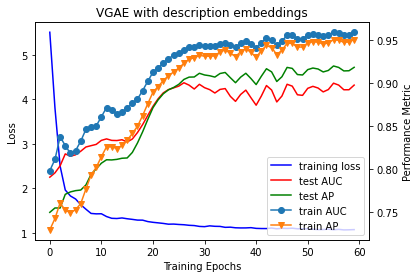

In [ ]:
plot_training_stats(MODEL_NAME + " with description embeddings", losses, test_auc, test_ap, train_aucs, train_aps)

Best Threshold=0.647948


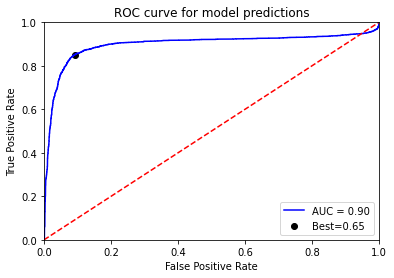

In [ ]:
plot_roc_curve(selected_model, test_dataset_with_features)

In [ ]:
visualize_tsne_embeddings(
    selected_model, train_dataset_with_features,
    title='Trained Model (using description embeddings): train set embeddings',
    labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:998: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
visualize_pca_embeddings(
    selected_model, train_dataset_with_features,
    title='Trained Model (using description embeddings): train set embeddings',
    labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:998: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



# 10) Conclusion: Use model to look at predictions!

Now that we have trained our model, we can take a look and see which genes are predicted to have connections with which diseases! Below is some beginner code to help analyze and query such information. To start, let us select from the set of datasets and models we've experimented with in this Colab.



In [ ]:
# Select particular model and dataset
data_object_to_analyze = data_object    # Choose from: data_object, data_object_with_features
model_to_analyze = vgae_model            # Choose from: gae_model, vgae_model, selected_model

print("DataObject:\n", data_object_to_analyze)
print("\nModel:\n", model_to_analyze)

DataObject:
 Data(num_nodes=7813, edge_index=[2, 42714], x=[7813, 20])

Model:
 VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(20, 200)
    (conv_mu): GCNConv(200, 20)
    (conv_logstd): GCNConv(200, 20)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): InnerProductDecoder()
)


Now, let us first get a ranking of the edges. Recall that we use a dot-product decoder for our GAE and VGAE models. Thus, to determine how confident our model is for a particular edge (u,v), we just need to take the dot product of the learned embeddings for u and v.

We do this below with the previously defined `get_ranked_edges` routine. Then, to get a sense of the distribution of dot products, we plot a histogram below. Notice the skewed distribution - all of our models show a distribution where a dot product larger than 10 appears to be significant.

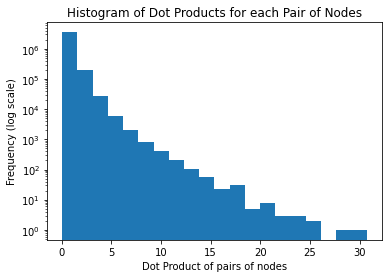

In [ ]:
# Get ranked edge list, filtered by the selected node ids.
ranked_edge_list, ranked_dot_products = get_ranked_edges(data_object_to_analyze, model_to_analyze)

# Plot histogram of the dot products
plt.hist(ranked_dot_products, bins=20)
plt.title("Histogram of Dot Products for each Pair of Nodes")
plt.yscale('log', nonposy='clip')
plt.ylabel("Frequency (log scale)")
plt.xlabel("Dot Product of pairs of nodes")
plt.show()

Next, let's take a look at these top edges. We can simply list the top edges, or we can select and rank the edges that are connected to particular gene nodes or disease nodes of interest.


> *An example query:*
>
> The BRCA1 and BRCA2 genes are well-studied in the medical literature - mutations in these genes are strongly linked to breast cancer. So let's query `select_gene_substrings=["BRCA"]` and `select_disease_substrings=["neoplasm"]`. The top results show that "BRCA" is linked to many cancers, including "mammary neoplasms", a medical term for breast cancer. Interestingly, it is also strongly linked with other types of cancer.

> **Note:** If you haven't already, you'll need to run the code in *Section 8a* ("Fetch gene and disease descriptions.") to construct the `full_df` used in the code below.

In [ ]:
# Select for particular examples
select_gene_substrings = ["BRCA"]
select_disease_substrings = ['neoplasm']

In [ ]:
# Filter data frame by the selected disease terms, and get their node ids.
if select_disease_substrings:
  dz_regex = "(?i)" + "|".join(select_disease_substrings)
  query_df = full_df[full_df['Disease Name'].str.contains(dz_regex)]
  query_dz_nodes = [dz_mapping[dz_id] for dz_id in query_df['Disease ID'].drop_duplicates().tolist()]
  # print("\nQueried Disease Nodes:\n", query_df['Disease Name'])
else:
  query_dz_nodes = None

# Filter data frame by the selected gene terms, and get their node ids.
if select_gene_substrings:
  gene_regex = "(?i)" + "|".join(select_gene_substrings)
  query_df = full_df[full_df['Gene Name'].notna()]
  query_df = query_df[query_df['Gene Name'].str.contains(gene_regex)]
  query_gene_nodes = [gene_mapping[gene_id] for gene_id in query_df['Gene ID'].drop_duplicates().tolist()]
  # print("\nQueried Gene Nodes:\n", query_df['Gene Name'])
else:
  query_gene_nodes = None


# Get reverse dz and gene mappings, to print out all needed info.
reverse_dz_mapping = {j: i for i,j in dz_mapping.items()}
reverse_gene_mapping = {j: i for i,j in gene_mapping.items()}

print("\nTop Predicted Edges")
top_k = 50
curr_k = 0
for dz_i, gene_i in ranked_edge_list:
  # Skip edges that do not include the selected dz and gene nodes
  if query_dz_nodes and dz_i not in query_dz_nodes:
    continue
  if query_gene_nodes and gene_i not in query_gene_nodes:
    continue

  # Get all the info needed (dz_i and gene_i are the node indeces)
  dz_id, gene_id = reverse_dz_mapping[dz_i], reverse_gene_mapping[gene_i]
  dz_description = full_df[full_df["Disease ID"] == dz_id]["Disease Name"].drop_duplicates().iloc[0]
  gene_description = full_df[full_df["Gene ID"] == gene_id]["Gene Name"].drop_duplicates().iloc[0]
  dot_product = ranked_dot_products[curr_k]

  print('edge=({},{}), \t dotprod={:.2f},\t descriptions=({},{})'.format(dz_i, gene_i, dot_product, dz_description, gene_description))

  curr_k += 1
  if curr_k > top_k:
    break


Top Predicted Edges
edge=(119,1108), 	 dotprod=30.71,	 descriptions=(Prostatic Neoplasms,BRCA1 associated protein 1)
edge=(280,1108), 	 dotprod=28.24,	 descriptions=(Mammary Neoplasms,BRCA1 associated protein 1)
edge=(479,1108), 	 dotprod=25.81,	 descriptions=(Stomach Neoplasms,BRCA1 associated protein 1)
edge=(119,2546), 	 dotprod=25.25,	 descriptions=(Prostatic Neoplasms,BRCA1 interacting protein C-terminal helicase 1)
edge=(91,1108), 	 dotprod=24.44,	 descriptions=(Colorectal Neoplasms,BRCA1 associated protein 1)
edge=(280,2546), 	 dotprod=23.73,	 descriptions=(Mammary Neoplasms,BRCA1 interacting protein C-terminal helicase 1)
edge=(242,1108), 	 dotprod=23.68,	 descriptions=(Neoplasm Metastasis,BRCA1 associated protein 1)
edge=(369,1108), 	 dotprod=22.22,	 descriptions=(Malignant neoplasm of prostate,BRCA1 associated protein 1)
edge=(479,2546), 	 dotprod=22.01,	 descriptions=(Stomach Neoplasms,BRCA1 interacting protein C-terminal helicase 1)
edge=(103,1108), 	 dotprod=21.58,	 descr